Predict the final price of each home based on provided aspects.
Each line is a different house

tutorial used: https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea

In [68]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
from lime import lime_tabular

In [69]:
## import house data

dtf = pd.read_csv("train.csv")
cols = ["OverallQual","GrLivArea","GarageCars", 
      "GarageArea","TotalBsmtSF","FullBath",
      "YearBuilt","YearRemodAdd",
      "LotFrontage","MSSubClass"]
dtf = dtf[["Id"]+cols+["SalePrice"]]
dtf.head()

,Id,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,SalePrice
0,1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
1,2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
2,3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
3,4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
4,5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000


In [70]:
'''
Recognize whether a column is numerical or categorical.
'''
def utils_recognize_type(dtf, col, max_cat = 20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

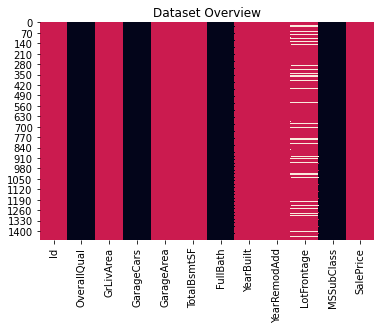

 Categerocial   Numeric   NaN 


In [71]:
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns}
heatmap = dtf.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [72]:
dtf = dtf.set_index("Id")
dtf = dtf.rename(columns={"SalePrice":"Y"})

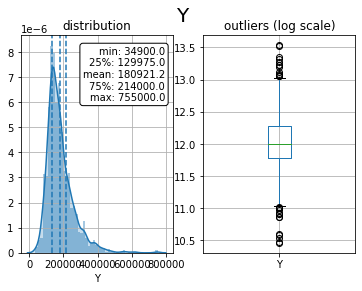

In [73]:
x = "Y"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
# variable = variable[ (variable > breaks[quantile_breaks[0]]) & (variable < breaks[quantile_breaks[1]]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

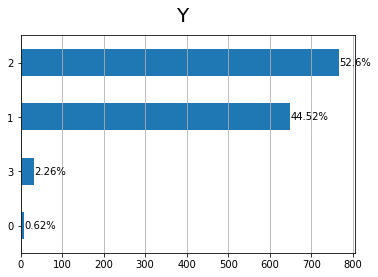

In [74]:
ax = dtf["FullBath"].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()

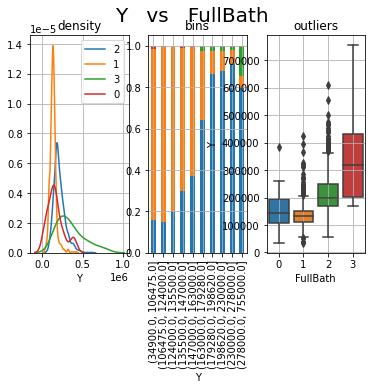

In [75]:
x = "Y"
y = "FullBath"
cat, num = "FullBath", "Y"
fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in dtf[cat].unique():
    sns.distplot(dtf[dtf[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(dtf[num], q=np.linspace(0,1,11))
tmp = dtf.groupby([cat, pd.cut(dtf[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[dtf[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
### boxplot   
ax[2].title.set_text('outliers')
sns.boxplot(x=cat, y=num, data=dtf, ax=ax[2])
ax[2].grid(True)
plt.show()

In [76]:
cat, num = "FullBath", "Y"
model = smf.ols(num+' ~ '+cat, data=dtf).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.0)


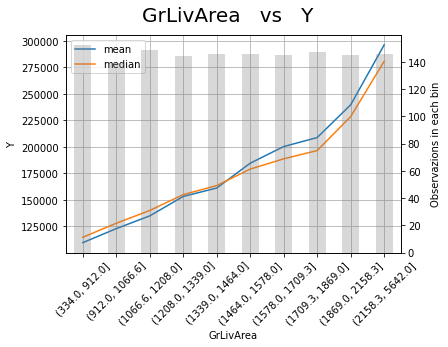

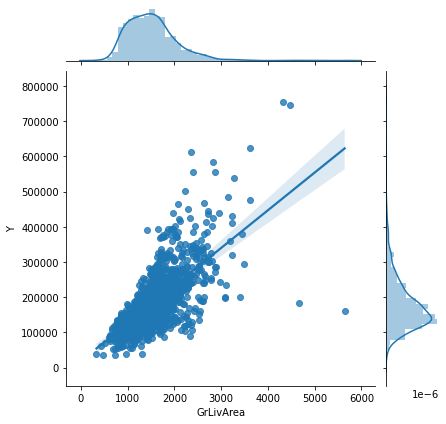

In [77]:
x, y = "GrLivArea", "Y"
### bin plot
dtf_noNan = dtf[dtf[x].notnull()]
breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))
groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])
fig, ax = plt.subplots()
fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observazions in each bin")
plt.show()
### scatter plot
sns.jointplot(x=x, y=y, data=dtf, dropna=True, kind='reg')
plt.show()

In [78]:
x, y = "GrLivArea", "Y"
dtf_noNan = dtf[dtf[x].notnull()]
coeff, p = scipy.stats.pearsonr(dtf_noNan[x], dtf_noNan[y])
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Pearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")

Pearson Correlation: 0.709 Significant (p-value: 0.0)


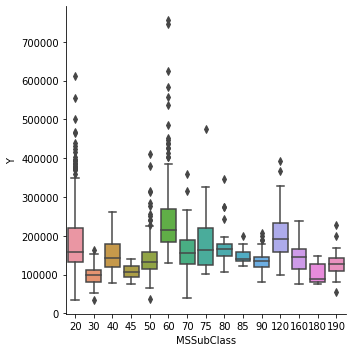

In [79]:
sns.catplot(x="MSSubClass", y="Y", data=dtf, kind="box")

In [81]:
## define clusters
x="MSSubClass"
MSSubClass_clusters = {"min":[30,45,180], "max":[60,120], "mean":[]}
## create new columns
dic_flat = {v:k for k,lst in MSSubClass_clusters.items() for v in lst}
for k,v in MSSubClass_clusters.items():
    if len(v)==0:
        residual_class = k 
dtf[x+"_cluster"] = dtf[x].apply(lambda x: dic_flat[x] if x in 
                          dic_flat.keys() else residual_class)
## print
dtf[["MSSubClass","MSSubClass_cluster","Y"]].head()

,MSSubClass,MSSubClass_cluster,Y
Id,,,
1,60,max,208500
2,20,mean,181500
3,60,max,223500
4,70,mean,140000
5,60,max,250000


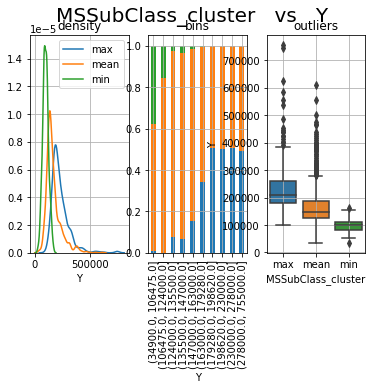

In [83]:
y = "Y"
x = "MSSubClass_cluster"
cat, num = "MSSubClass_cluster", "Y"
fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in dtf[cat].unique():
    sns.distplot(dtf[dtf[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(dtf[num], q=np.linspace(0,1,11))
tmp = dtf.groupby([cat, pd.cut(dtf[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[dtf[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
### boxplot   
ax[2].title.set_text('outliers')
sns.boxplot(x=cat, y=num, data=dtf, ax=ax[2])
ax[2].grid(True)
plt.show()